## 🎬 **The FliX Files: Misteries of Netflix**

The truth is out there... and so is Netflix's ever-expanding library. From sci-fi thrillers to heartwarming rom-coms, Netflix has something for everyone (even if we still spend 30 minutes deciding what to watch). But have you ever wondered what secrets lurk behind the Play button?

This notebook is here to investigate the mysteries of Netflix! We'll decode its data, uncover trends, create some cool graphs and find out that what can the data tell us about Netflix's and their users habits.

### **Case Files:**
- 🎞️ Movies vs. TV Shows: Which format reigns supreme?
- 🌍 Geographics: Where do they come from?
- 📈 Release Year Trends: Has Netflix been getting better, or are we just nostalgic?
- 🎭 Genre Hotspots: From aliens to rom-coms, what do viewers love?


So, grab your trench coat 🕵️, turn up the spooky music 🎵, and let's crack open The FliX Files. The mysteries of Netflix are waiting to be revealed!

## PREPARING THE ENVIRONMENT:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pandas.api.types import CategoricalDtype
import warnings

warnings.filterwarnings("ignore")

bg_image = mpimg.imread("/kaggle/input/netflix-background/netflix_bg.jpeg") 
netflix_bg = "#221F1F"
netflix_palette = [
    "#E50914",  # Netflix Red
    "#F5F5F1",  # White Smoke
    "#1F78B4",  # Deep Cyan
    "#FFC107",  # Golden Yellow
    "#9C27B0",  # Electric Purple
    "#4CAF50",  # Leaf Green
    "#FF5722"   # Orange Coral
]

# Load data
data = pd.read_csv("/kaggle/input/netflix-movies-and-tv-shows/netflix_titles.csv")

In [2]:
# Universal barplot function for efficiency and readability (in a bit complicated, but very detailed way)
def create_barplot(var, title, xlab, ylab, xlim, ylim):
    era_counts = var.value_counts(sort=False)
    col_pal = [netflix_palette[5],netflix_palette[1], netflix_palette[3], netflix_palette[2]]

    # Configure plot
    plt.figure(facecolor=netflix_bg, figsize=(12, 6))  # Increase figure size
    plt.style.use("dark_background")
    bars = plt.bar(era_counts.index, era_counts.values, color= col_pal, width = 0.5, alpha=0.75)
    plt.xlabel(xlab, fontsize=13, labelpad=10)
    plt.ylabel(ylab, fontsize=13, labelpad=10)
    plt.title(title, fontsize=14, pad=15)
    
    # Annotate bar heights
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 60,
                 str(bar.get_height()), ha="center", fontsize=12, color=col_pal[bars.index(bar)])
    
    # Add grid lines, background image and other styling
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    ax = plt.gca()
    ax.imshow(bg_image, extent=[0, xlim-0.5, 0, ylim], aspect="auto", zorder=-2, alpha = 0.25)
    ax.set_facecolor(netflix_bg)
    ax.set_xlim(-0.5, xlim)
    ax.set_ylim(0, ylim)
    
    plt.tight_layout()
    plt.show()

## ANALYSIS:

### 1. A Quick Look at the Data...

In [3]:
# Let's see what's hidden in the dataset.
# Yes, .info() is much simpler, but we're looking for a sophisticated and beautiful solution.
# This way we will have a variable that we can even export.

df_info = pd.DataFrame({
    "Column Name": data.columns,
    "Non-Null Count": data.notnull().sum(),
    "Data Type": data.dtypes.astype(str),
    "Missing Values": data.isnull().sum(),
    "Missing %": (data.isnull().sum() / len(data)*100).round(2),
    "Unique Values": data.nunique()
}).reset_index(drop=True)

df_info

,Column Name,Non-Null Count,Data Type,Missing Values,Missing %,Unique Values
0,show_id,8807,object,0,0.00,8807
1,type,8807,object,0,0.00,2
2,title,8807,object,0,0.00,8807
3,director,6173,object,2634,29.91,4528
4,cast,7982,object,825,9.37,7692
5,country,7976,object,831,9.44,748
6,date_added,8797,object,10,0.11,1767
7,release_year,8807,int64,0,0.00,74
8,rating,8803,object,4,0.05,17
9,duration,8804,object,3,0.03,220


### What did we find?
- Our data is mostly textual and categorical. It is important to choose analysis tools accordingly.
- We must handle missing values for the variables we want to work with.

### About the clues...

We have some interesting factors (variables) here that we can start with... but wait, what do we want to know exactly?
- 📈 How has Netflix grown over the years?
- 🌍 Where do the titles come from?
- 🎞️ How has the number of movies and TV Shows changed over the years?
- ⏳ How has the duration of movies and TV Shows changed over the past decades?
- 🎭 Which genres dominate Netflix's repertoire?

### 2. Preparing data for analysis and visualization

#### Omit Unnecessary Variables, Convert Variables & Dealing with Missings:
- We don't need "director", "cast", "date_added" and "description" columns because they are not relevant to our questions.
- The duration variable is currently a string, making it difficult to work with, so we'll transform it by removing the "min" and "season(s)" suffixes.
- At the moment, the only column where we have to deal with missing values is the duration of movies and TV shows.

In [4]:
# Omit unnecessary variables
data = data.drop(columns=["director", "cast", "date_added", "description"])

# Dealing with missing values in duration
data = data.dropna(subset = ["duration"])

# Transform durability variable
data["duration"] = (
    data["duration"]
    .str.replace(" min", "", regex=False)  # Remove ' min'
    .str.replace(" Seasons", "", regex=False) # Remove ' Seasons'
    .str.replace(" Season", "", regex=False)  # Remove ' Season'
    .astype(int)  # Convert to integer if no decimals are expected
)

#### New variables: release eras, categories for durations and transform genres (listed_in)
- We need to know the min and max values of these variables. In the case of the duration variable, it is important to examine the values for movies and TV Shows separately.

In [5]:
# Looking for min and max values in release year and duration variables
release_year_desc = data["release_year"].describe().rename("release_year_stats")
movie_duration_desc = data["duration"][data["type"] == "Movie"].describe().rename("movie_duration_stats")
tv_show_duration_desc = data["duration"][data["type"] == "TV Show"].describe().rename("tv_show_duration_stats")

# Combine into a single DataFrame
summary_df = pd.concat([release_year_desc, movie_duration_desc, tv_show_duration_desc], axis=1)
summary_df

,release_year_stats,movie_duration_stats,tv_show_duration_stats
count,8804.000000,6128.000000,2676.000000
mean,2014.180259,99.577187,1.764948
std,8.820647,28.290593,1.582752
min,1925.000000,3.000000,1.000000
25%,2013.000000,87.000000,1.000000
50%,2017.000000,98.000000,1.000000
75%,2019.000000,114.000000,2.000000
max,2021.000000,312.000000,17.000000


##### We now have access to the information we need to create the new categories for later analysis.

In [6]:
# Creating a categorical variable from release year
# Define bins and labels for eras
bins = [1925, 1970, 2000, 2016, 2022]
labels = ["Before 1970", "1970-1999", "2000-2015", "After 2015"]

# Create a new categorical column and convert to ordered categorical
data["release_era"] = pd.cut(data["release_year"], bins=bins, labels=labels, right=False, ordered=True)
data["release_era"] = pd.Categorical(data["release_era"], categories=labels, ordered=True)



In [7]:
# Creating a categorical variable from 'duration' variable (for movies and TV Shows separately)

# Define bins and labels for Movies (in minutes)
movie_bins = [0, 60, 90, 150, 500]  # Example bins (0-60, 61-90, etc.)
movie_labels = ["Very Short (<1hr)", "Short (1-1.5hr)", "Medium (1.5-2.5hr)", "Very Long (>2.5hr)"]

# Define bins and labels for TV Shows (in seasons)
tv_bins = [0, 2, 3, 8, 25]  # Example bins (1, 2-3, 4-6, etc.)
tv_labels = ["Mini-Series (1 season)", "Short Series (2-3 seasons)", 
             "Long Series (4-8 seasons)", "Very Long Series (>8 seasons)"]

# Just for avoid warnings
movies = data[data["type"] == "Movie"].copy()
tv_shows = data[data["type"] == "TV Show"].copy()

# duration_cat for Movies
movies["duration_cat"] = pd.Categorical(
    pd.cut(movies["duration"], bins=movie_bins, labels=movie_labels, right=False),
    categories=movie_labels,
    ordered=True
)

# duration_cat for TV Shows
tv_shows["duration_cat"] = pd.Categorical(
    pd.cut(tv_shows["duration"], bins=tv_bins, labels=tv_labels, right=False),
    categories=tv_labels,
    ordered=True
)

# Combine the data back
data = pd.concat([movies, tv_shows])



In [8]:
# Transform genres (listed_in column) to a better form (merged and normalized)

# Formatting
data["listed_in"] = data["listed_in"].astype(str)

# Create a dummy table
genres_dummies = data["listed_in"].str.get_dummies(sep=', ')

# Combine genres with release_era
genre_trends = genres_dummies.join(data["release_era"]).groupby("release_era").sum()

# Define genre mapping dictionary for merging
genre_mapping = {
    "Documentary": ["Documentaries", "Docuseries", "Science & Nature TV"],
    "International": ["International TV Shows", "International Movies", "British TV Shows", "Spanish-Language TV Shows", "Korean TV Shows"],
    "Drama": ["TV Dramas", "Dramas", "Independent Movies"],
    "Mystery & Crime": ["TV Mysteries", "Crime TV Shows", "TV Thrillers", "Thrillers"],
    "Action & Adventure": ["TV Action & Adventure", "Action & Adventure"],
    "Reality & Talk Shows": ["Reality TV", "Stand-Up Comedy & Talk Shows"],
    "Romance": ["Romantic TV Shows", "Romantic Movies"],
    "Comedy": ["TV Comedies", "Comedies", "Stand-Up Comedy"],
    "Horror": ["TV Horror", "Horror Movies"],
    "Sci-Fi & Fantasy": ["TV Sci-Fi & Fantasy", "Sci-Fi & Fantasy"],
    "Kids & Family": ["Children & Family Movies", "Kids' TV"],
    "Classic & Cult": ["Classic Movies", "Cult Movies", "Classic & Cult TV"],
    "Anime": ["Anime Features", "Anime Series"],
    "Sports": ["Sports Movies"],
    "Music & Musicals": ["Music & Musicals"],
    "Teen Shows": ["Teen TV Shows"],
    "Faith & Spirituality": ["Faith & Spirituality"],
    "LGBTQ": ["LGBTQ Movies"]
}

# Merging genres to new categories
reverse_mapping = {old_genre: new_genre for new_genre, old_genres in genre_mapping.items() for old_genre in old_genres}

# Create new merged genre table
merged_genres = pd.DataFrame(index=data.index)

# Loop through each row and assign genres to their category
for genre, new_category in reverse_mapping.items():
    if genre in data["listed_in"].str.get_dummies(sep=", ").columns:
        merged_genres[new_category] = data["listed_in"].str.contains(genre).astype(int)

# Add release_era column
merged_genres["release_era"] = data["release_era"]

# Group by `release_era` and sum genre occurrences
genre_trends_merged = merged_genres.groupby("release_era").sum()

### 3. Visualizations

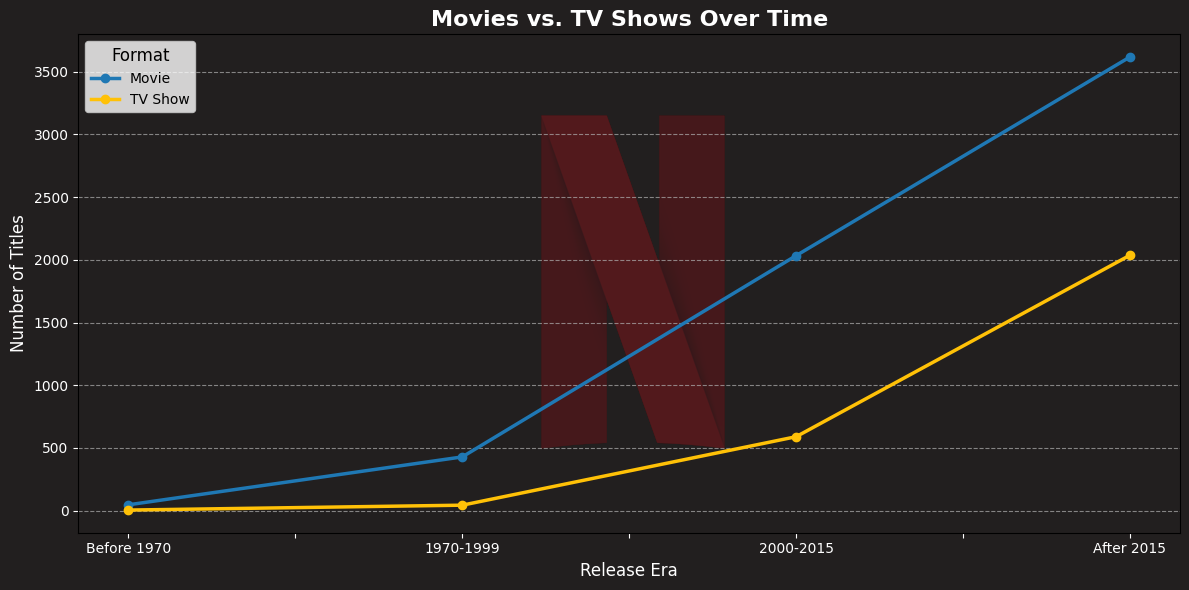

In [9]:
# Count Movies and TV Shows by release_era
format_trends = data.groupby(["release_era", "type"]).size().unstack().fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(12, 6), facecolor="#221F1F")
fig.figimage(bg_image, xo=405, yo=80, alpha=0.25, zorder=-10)

# Line plot for Movies vs TV Shows
format_trends.plot(kind="line", marker="o", linewidth=2.5, ax=ax, color=[netflix_palette[2], netflix_palette[3]])

# Titles & Labels
ax.set_title("Movies vs. TV Shows Over Time", fontsize=16, fontweight="bold", color="white")
ax.set_xlabel("Release Era", fontsize=12, color="white")
ax.set_ylabel("Number of Titles", fontsize=12, color="white")

# Ticks and Grid
ax.tick_params(axis="x", colors="white")
ax.tick_params(axis="y", colors="white")
ax.legend(title="Format", fontsize=10, title_fontsize=12, loc="upper left")
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.set_facecolor("none")

# Show the plot
plt.tight_layout()
plt.show()


It seems that movies have been showing up in greater numbers since the beginning. Although series are following the trend, it seems that there is no real chance that they will become the majority in the near future. However, let's not forget that a series can keep viewers busy for years, while movies are far from it.

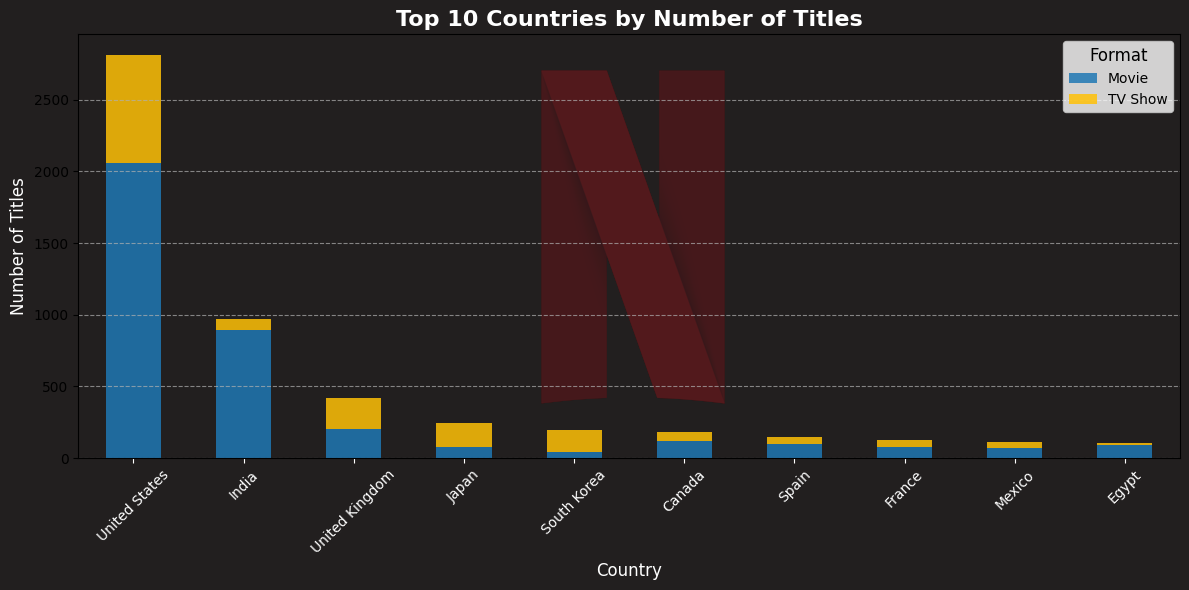

In [10]:
# Group data by country and type, count titles and calculate total titles per country and select TOP10
country_trends = data.groupby(["country", "type"]).size().unstack(fill_value=0)
top_countries = country_trends.sum(axis=1).sort_values(ascending=False).head(10)

# Filter data for the top 10 countries
top_country_trends = country_trends.loc[top_countries.index]

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6), facecolor="#221F1F")
fig.figimage(bg_image, xo=405, yo=125, alpha=0.25, zorder=-10)
top_country_trends.plot(kind='bar', stacked=True, ax=ax, color=[netflix_palette[2], netflix_palette[3]], alpha=0.85)

# Titles and labels
ax.set_title("Top 10 Countries by Number of Titles", fontsize=16, fontweight="bold", color="white")
ax.set_xlabel("Country", fontsize=12, color="white")
ax.set_ylabel("Number of Titles", fontsize=12, color="white")

# Customize ticks and legend
ax.tick_params(axis="x", colors="white", rotation=45)
ax.legend(title="Format", fontsize=10, title_fontsize=12, loc="upper right")
ax.set_facecolor("none")

# Grid
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

The United States dominates Netflix's catalog, it has the largest number of both Movies and TV Shows. This reflects Netflix’s origins as a US-based company and its strong focus on catering to its home audience. India’s growing contribution showcases Netflix’s focus on international expansion, particularly in regions with large populations and rising streaming demand. The UK has a strong presence, likely driven by high-quality British TV Shows and dramas.

It is also interesting that in the UK, Japan and South Korea the proportion of series is equal to or greater than the proportion of films.

### What about release eras and duration of the titles?

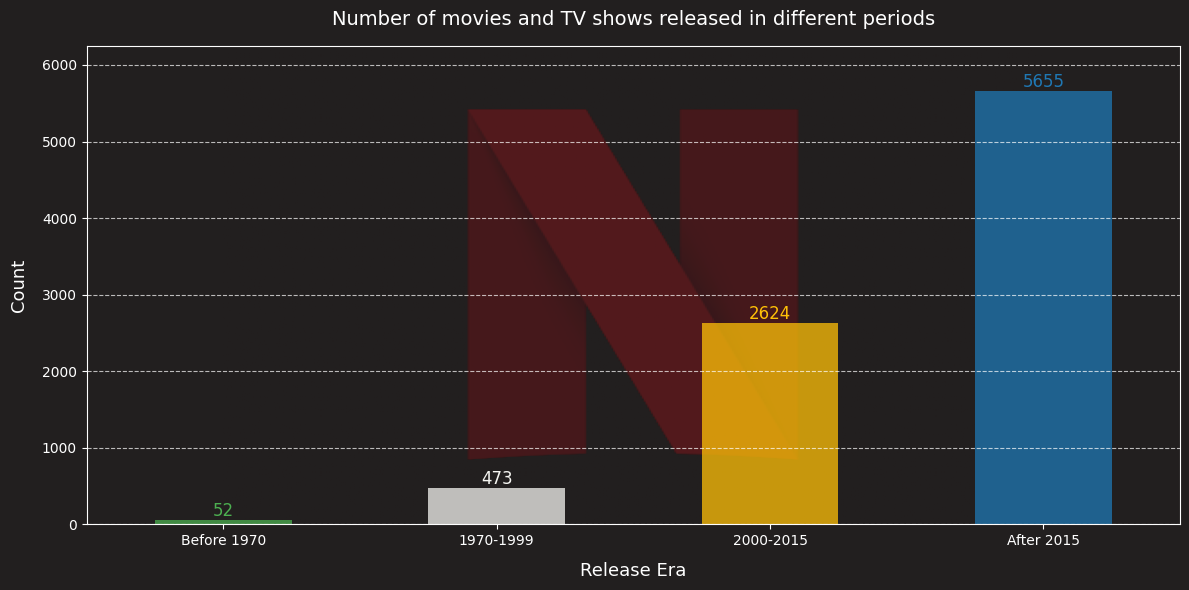

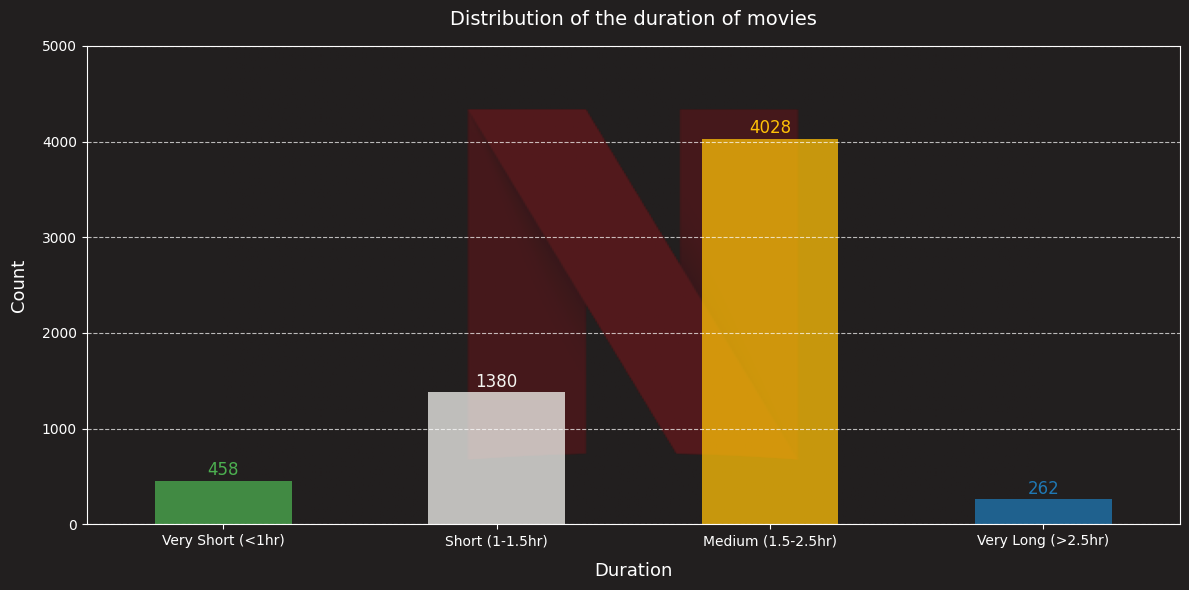

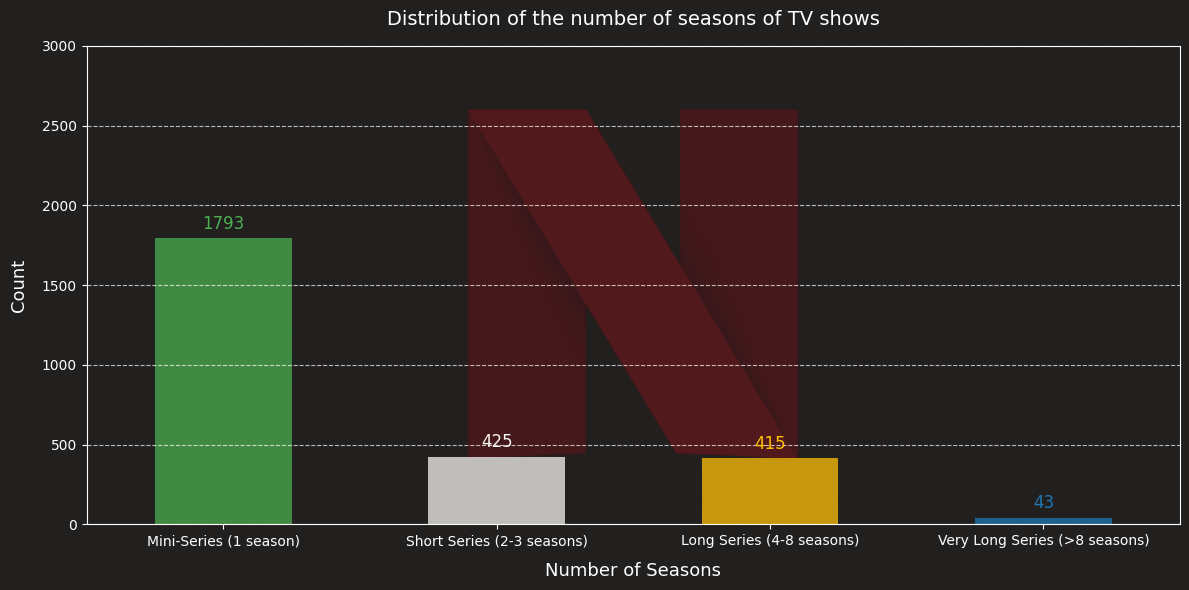

In [11]:
# Visualize releases by eras
create_barplot(data["release_era"],
              title = "Number of movies and TV shows released in different periods",
              xlab = "Release Era", ylab = "Count",
              xlim = 3.5, ylim = 6250)

# Visualize duration categories for movies
create_barplot(var = movies["duration_cat"],
              title = "Distribution of the duration of movies",
              xlab = "Duration", ylab = "Count",
              xlim = 3.5, ylim = 5000)

# Visualize duration categories for TV Shows
create_barplot(var = tv_shows["duration_cat"],
              title = "Distribution of the number of seasons of TV shows",
              xlab = "Number of Seasons", ylab = "Count",
              xlim = 3.5, ylim = 3000)

As we can see, in recent years, more movies and TV shows have been released than in any previous period. This can mostly be attributed to the rapid development of the film industry and technology, but the question arises as to how much this crazy pace affects the quality of the content.

It's clearly seen that in the case of movies, the average length dominates (1.5-2.5h), while in the case of series, it can be observed that most series do not survive beyond the first season.

### Let's see how the duration of movies and TV Shows has changed over time...

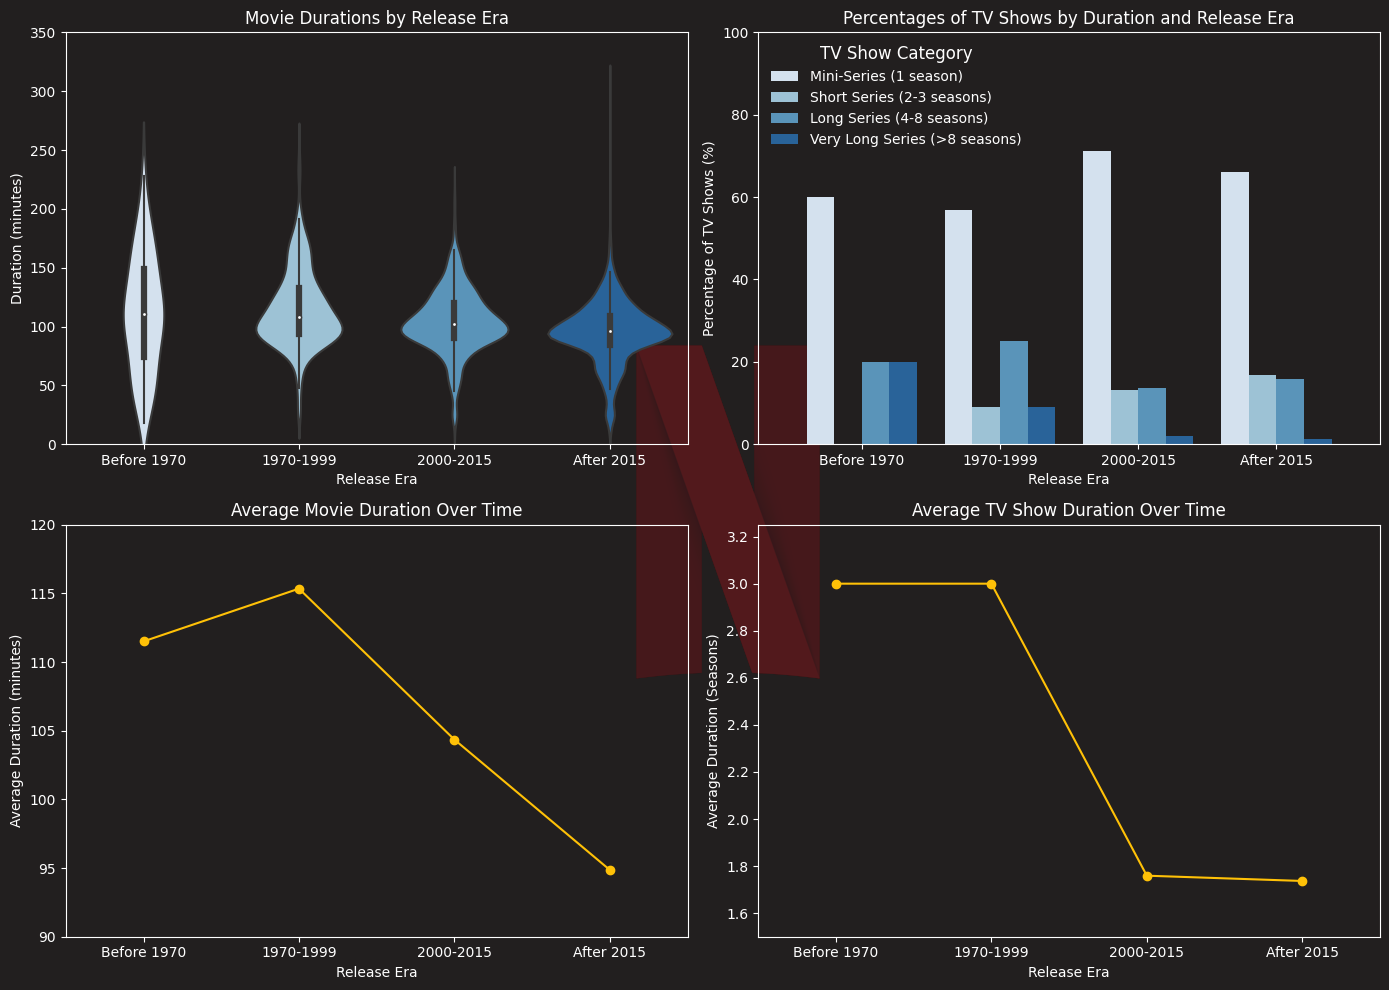

In [12]:
# Style Setup
plt.style.use("dark_background")

# Define Orders
release_era_order = ["Before 1970", "1970-1999", "2000-2015", "After 2015"]
duration_order = ["Mini-Series (1 season)", "Short Series (2-3 seasons)", 
                  "Long Series (4-8 seasons)", "Very Long Series (>8 seasons)"]

# Setup main plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10), facecolor=netflix_bg)

# Set the main background image
fig.figimage(bg_image, xo=500, yo=250, alpha=0.25, zorder=-10)

# Make all subplots transparent & apply common settings
for ax in axes.flat:
    ax.set_facecolor("none")

# 1. Violin Plot (TV Show Durations)
sns.violinplot(x="release_era", y="duration", data=movies, ax=axes[0, 0], palette="Blues")
axes[0, 0].set_title("Movie Durations by Release Era")
axes[0, 0].set_xlabel("Release Era")
axes[0, 0].set_ylabel("Duration (minutes)")
axes[0, 0].set_xlim(-0.5, 3.5)
axes[0, 0].set_ylim(0, 350)

# 2. Bar Plot (TV Show Category Percentage)
tv_count = tv_shows.groupby(["release_era", "duration_cat"], observed=True).size().reset_index(name="count")
tv_count["percentage"] = tv_count.groupby("release_era")["count"].transform(lambda x: (x / x.sum()) * 100)

sns.barplot(x="release_era", y="percentage", hue="duration_cat", data=tv_count, 
            palette="Blues", order=release_era_order, hue_order=duration_order, ax=axes[0, 1])

axes[0, 1].set_title("Percentages of TV Shows by Duration and Release Era")
axes[0, 1].set_xlabel("Release Era")
axes[0, 1].set_ylabel("Percentage of TV Shows (%)")
axes[0, 1].set_xlim(-0.75, 3.75)
axes[0, 1].set_ylim(0, 100)
axes[0, 1].legend(title="TV Show Category", title_fontsize=12, fontsize=10, loc="upper left", frameon=False)

# 3. Line Plot (Average Movie Duration)
movie_avg = movies.groupby("release_era", observed=True)["duration"].mean()
axes[1, 0].plot(movie_avg.index, movie_avg.values, marker="o", linestyle="-", color=netflix_palette[3])
axes[1, 0].set_title("Average Movie Duration Over Time")
axes[1, 0].set_xlabel("Release Era")
axes[1, 0].set_ylabel("Average Duration (minutes)")
axes[1, 0].set_xlim(-0.5, 3.5)
axes[1, 0].set_ylim(90, 120)

# 4. Line Plot (Average TV Show Duration)
tv_shows_avg = tv_shows.groupby("release_era", observed=True)["duration"].mean()
axes[1, 1].plot(tv_shows_avg.index, tv_shows_avg.values, marker="o", linestyle="-", color=netflix_palette[3])
axes[1, 1].set_title("Average TV Show Duration Over Time")
axes[1, 1].set_xlabel("Release Era")
axes[1, 1].set_ylabel("Average Duration (Seasons)")
axes[1, 1].set_xlim(-0.5, 3.5)
axes[1, 1].set_ylim(1.5, 3.25)

# Adjust Layout & Show
plt.tight_layout()
plt.show()

As can be seen, the distribution of the duration of movies has fallen to a much narrower range over the years. The duration of most movies has gradually narrowed to an average of around 100 minutes and the proportion of short and very long movies is much smaller. However, the extra-long movies made in recent years also dramatically change the graph.

In the case of TV Shows, the 1-season length dominates in all periods. It is also clear that in the past, longer-lived TV Shows were much more typical, while series longer than 8 seasons have almost disappeared.

In terms of average movie duration in the given period, it can be said that before 2000, the average length of films was well over 100 minutes, while today this has decreased significantly. The trend is similar in the case of series. Before 2000, a series lasted an average of 3 seasons, today it is between 1.6 and 1.8 seasons on average.

This is not surprising. There are many more movies and series being released and viewers is being distributed much more widely, resulting in more series being abandoned due to deteriorating viewership statistics.

### Now let's see what the situation is with genres...

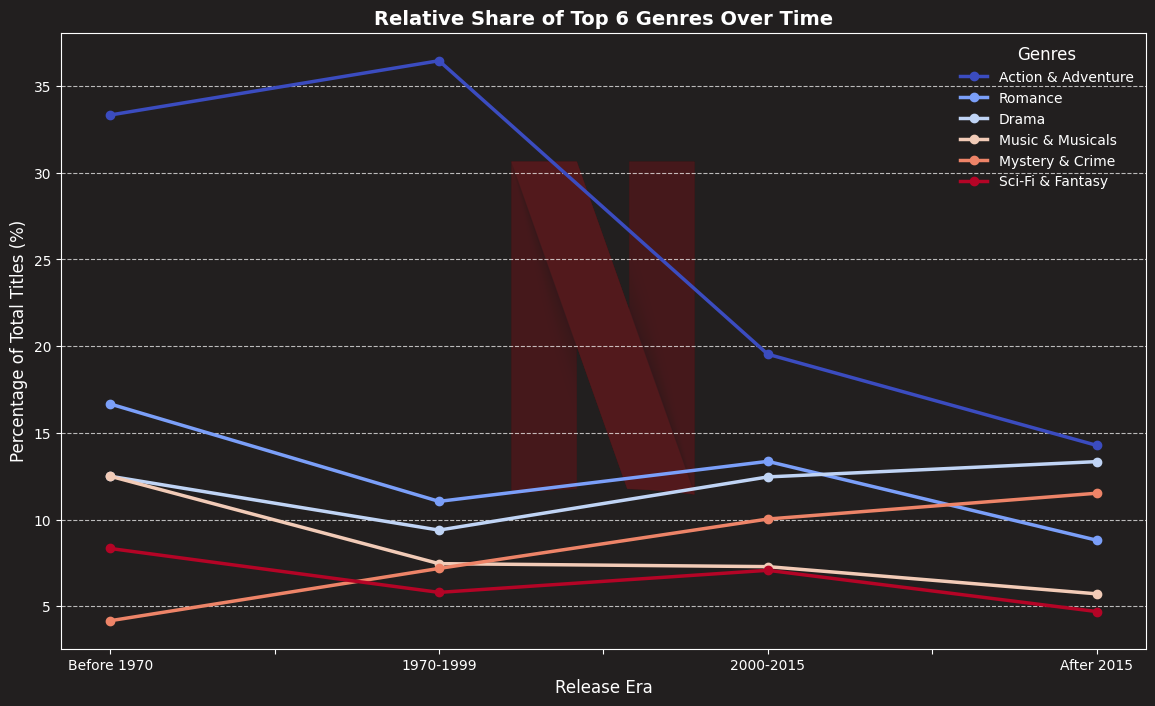

In [13]:
# Normalize genre trends to avoid absolute distortion
normalized_genre_trends = genre_trends_merged.div(genre_trends_merged.sum(axis=1), axis=0) * 100

# Select the top 6 genres based on total prop
top_genres_normalized = normalized_genre_trends.sum().sort_values(ascending=False).head(6).index

fig, ax = plt.subplots(figsize=(14, 8), facecolor="#221F1F")
fig.figimage(bg_image, xo=375, yo=150, alpha=0.25, zorder=-10)

# Plot
normalized_genre_trends[top_genres_normalized].plot(kind="line", marker="o", linewidth=2.5, ax=ax, colormap="coolwarm")

# Titles & Labels
ax.set_title("Relative Share of Top 6 Genres Over Time", fontsize=14, fontweight="bold", color="white")
ax.set_xlabel("Release Era", fontsize=12, color="white")
ax.set_ylabel("Percentage of Total Titles (%)", fontsize=12, color="white")

# Adjust legend and other styling
ax.legend(title="Genres", fontsize=10, title_fontsize=12, loc="upper right", frameon=False)
ax.grid(axis='y', linestyle="--", alpha=0.7)
ax.set_facecolor("none")

plt.show()


There is an interesting trend in terms of genres. The 6 most popular genres are action and adventure, romance, drama, music, crime, sci-fi, and fantasy. Action and adventure genres dominated the offer to a large extent before 1970, which continued to increase until the 2000s. After that, however, the proportion of films belonging to this genre decreased.

The situation of other genres has not changed significantly over the decades, although the proportion of romantic films and series has fallen by almost 8%, while crime is becoming an increasingly common genre. Sci-fi and fantasy have also seen better days, the proportion of around 7-8% has now fallen to below 5%. The number of dramas overall has not changed significantly.

### We should look at the situation with languages, don't you think? But we don't have such a variable. No problem, let's create one...

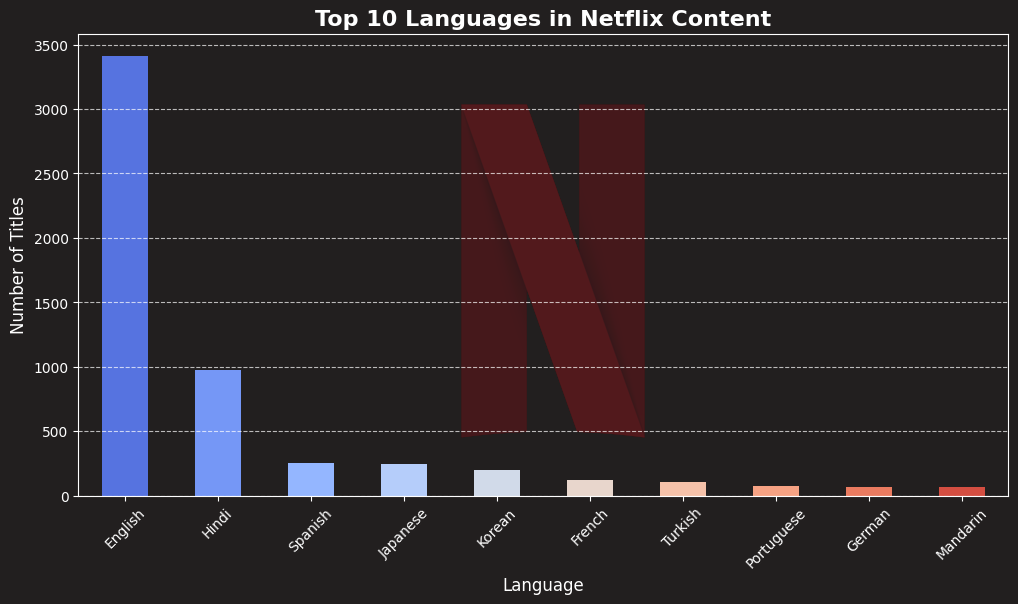

In [14]:
# Define a mapping of countries to their dominant languages
language_mapping = {
    "United States": "English",
    "India": "Hindi",   # Prioritizing Hindi over English for simplicity since more people speak Hindi
    "United Kingdom": "English",
    "Japan": "Japanese",
    "South Korea": "Korean",
    "Canada": "English",   # Prioritizing English over French for simplicity since more people speak English
    "France": "French",
    "Germany": "German",
    "Mexico": "Spanish",
    "Spain": "Spanish",
    "Turkey": "Turkish",
    "Brazil": "Portuguese",
    "Italy": "Italian",
    "China": "Mandarin",
}

# Apply mapping
data["primary_language"] = data["country"].map(language_mapping)

# Drop "Other" category, because it's too large and distorts the results
# (In both cases, it causes distortion, but it is more convenient this way. I interpret the results with this in mind.)
data[data["primary_language"].isna()].head(20)
data = data[data["primary_language"].notna()]

# Count total titles by language
language_trends = data["primary_language"].value_counts().head(10)  # Top 10 languages

# 📊 Bar Chart: Top Languages on Netflix
fig, ax = plt.subplots(figsize=(12, 6), facecolor="#221F1F")
fig.figimage(bg_image, xo=325, yo=105, alpha=0.25, zorder=-10)

language_trends.plot(kind="bar", ax=ax, color=sns.color_palette("coolwarm", len(language_trends)))

ax.set_title("Top 10 Languages in Netflix Content", fontsize=16, fontweight="bold", color="white")
ax.set_xlabel("Language", fontsize=12, color="white")
ax.set_ylabel("Number of Titles", fontsize=12, color="white")

ax.tick_params(axis="x", colors="white", rotation=45)
ax.tick_params(axis="y", colors="white")
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.set_facecolor("none")

plt.show()


When examining the linguistic distribution, it is necessary to **take into account the distortion** caused by the fact that the linguistic data was created based on the most typical language in each country, as well as approx. 3000 observations were omitted as categorization was not possible. The reason for this is, on the one hand, the missing values of the country variable, as well as the rows that contain several countries. Both problems could be handled, but since there is still enough data for visualization, we will not do it this time.

Even considering the limitations, English is clearly the most common language. This is not a big news. In the case of the other languages, the results are to be treated with strong reservations. In a later version, it might be worth revising this section.

If you are interested in more accurate linguistic results, drop a comment below and motivate me. 😀⚡️

## 🎬 Wrapping Up: The FliX Files Uncovered
Netflix's vast content library tells a fascinating story of how the entertainment industry has evolved over time. From the dominance of movies to the ever-growing presence of TV shows, the platform continuously adapts to global trends and viewer preferences.

### 🔍 Key Takeaways:
- 📌 Movies have always ruled, and while TV Shows are growing, they likely won’t surpass movies anytime soon. However, it is undeniable one long-running series can hold an audience for years.
- 📌 The U.S. remains Netflix’s powerhouse, but India, the UK, Japan, and South Korea are key international contributors, especially in TV content.
- 📌 More content than ever is being released, but at what cost? With increasing competition, many TV shows don’t survive beyond one season.
- 📌 Movies have settled into a 100-minute sweet spot, and extra-long films have become rare. Meanwhile, long-running TV series are becoming a thing of the past.
- 📌 Genre trends have shifted. Action & Adventure once reigned supreme but has declined in favor of Crime and Mystery. Meanwhile, Sci-Fi & Fantasy and Romance has lost ground.
- 📌 In addition to English, Hindi, Spanish, Japanese and Korean languages seem to dominate, but further clarification is needed in this area.


Netflix has changed the way we consume entertainment, and its evolution is far from over. Whether it's the rise of international content, the shortening of TV series lifespans, or the changing tastes in genres, one thing is clear: streaming is shaping the future of storytelling.

This investigation is far from complete, there is still a lot to research. Please share your thoughts and opinions. 📢 I look forward to it.